In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [38]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import Ridge

In [39]:
dataset_name = f'chewie_10_07'
model_str='kl1_gauss_bd_d20_causal_ci'

bin_size_ms = 10

In [68]:
models_dest = f"/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/{dataset_name}"

fac_dim, co_dim = 100,0
encod_seq_len = 101
encod_data_dim = 207

# model_names = ['240520_lfads_minloss_KL1', '240520_band_minloss_KL1']
from itertools import product
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_str,model_name in \
               product(['baseline',model_str],['lfads','band'])]
# model_names[0] += '_bs256'
model_dests = [f"{models_dest}/{model_name}" for model_name in model_names]

model_dests


['/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/lfads_both_100f_0c_baseline',
 '/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/band_both_100f_0c_baseline',
 '/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/lfads_both_100f_0c_kl1_gauss_bd_d20_causal_ci',
 '/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/band_both_100f_0c_kl1_gauss_bd_d20_causal_ci']

In [69]:
# model_dests[0] = '/disk/scratch/nkudryas/BAND-torch/runs/pbt-default-lfads/chewie_10_07/lfads_both_100f_4c_baseline'

In [70]:
path = f'../../datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_go.h5'
data = h5py.File(path, 'r')
data.keys()

true_target_direction = data['valid_target_direction']
epoch = data['valid_epoch'][:]
vel = data['valid_vel'][:]

train_vel = data['train_vel'][:]
train_target_direction = data['train_target_direction']
train_epoch = data['train_epoch'][:]


path = '../../results/Chewie_CO_FF_2016-10-07.h5'
data = {}
with h5py.File(path, 'r') as f:
   for key in f.keys():
      data[key] = f[key][()]
data.keys()

avg_vel_per_epoch = data['test_all_avg_per_epoch_pred']


In [71]:
# Get the paths to all data files
both_pca = []
both_tsne = []
pred_vels = []
for model_name, model_dest in zip(model_names,model_dests):
    data_path = os.path.join(model_dest,'best_model',f'lfads_output_go.h5')
    # Data is binned at 10 ms
    print(data_path)
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        train_ic = f['train_gen_init'][:]
        ic = f['valid_gen_init'][:]
        factors = f['valid_factors'][:]
        train_factors = f['train_factors'][:]
        pred_vel = f['valid_output_behavior_params'][:]
  
    # Ridge regression to predict velocity from factors    
    if 'lfads' in model_name:
        ridge = Ridge(alpha=1.0, fit_intercept=True)
        X = train_factors.reshape(train_factors.shape[0], -1)  # Flatten the factors
        y = train_vel.reshape(train_vel.shape[0], -1)  # Flatten the velocity
        ridge.fit(X, y)
        pred_vel = ridge.predict(factors.reshape(factors.shape[0], -1)).reshape(-1, *train_vel.shape[1:])

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    print(train_ic.shape,ic_pca.shape)

    # t-SNE of initial conditions
    tsne = TSNE(n_components=2, perplexity=min(ic.shape[0]//2,30.0))
    ic_tsne = tsne.fit_transform(ic)
    print(ic_tsne.shape)
            
    both_pca.append(ic_pca)
    both_tsne.append(ic_tsne)
    pred_vels.append(pred_vel)



/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/lfads_both_100f_0c_baseline/best_model/lfads_output_go.h5
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(465, 200) (116, 2)
(116, 2)
/disk/scratch/nkudryas/BAND-torch/runs/pbt-no-control/chewie_10_07/band_both_100f_0c_baseline/best_model/lfads_outpu

In [72]:
pred_vels[0].shape, vel.shape

((116, 101, 2), (116, 101, 2))

In [73]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

target_ids = get_target_ids(true_target_direction)

/tmp/ipykernel_446352/2235650691.py:15: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(*ic_pca[(epoch==e) & (target_ids==t)].T,edgecolors=cmap(t),marker=m,
/tmp/ipykernel_446352/2235650691.py:15: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(*ic_pca[(epoch==e) & (target_ids==t)].T,edgecolors=cmap(t),marker=m,
/tmp/ipykernel_446352/2235650691.py:15: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This be

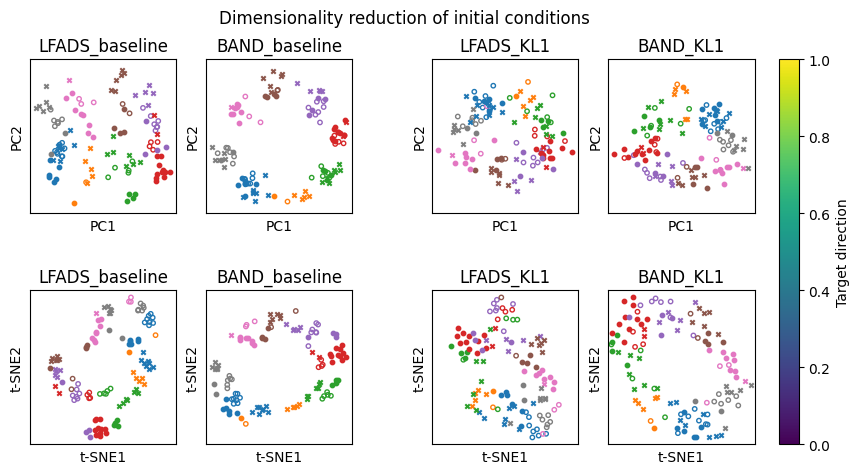

In [74]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2,4,figsize=(10,5))
fig.suptitle('Dimensionality reduction of initial conditions')

ccolors = plt.get_cmap(cm.tab10)(np.arange(8, dtype=int))
cmap = ListedColormap(ccolors)

for model_name, model_dest, ic_pca, ic_tsne, ax in zip(['LFADS_baseline','BAND_baseline',
                                                        'LFADS_KL1','BAND_KL1'], 
                                                       model_dests, both_pca, both_tsne, 
                                                       axes.T):
    for e,m in zip([0,1,2],['o','x','o']):
        for t in range(8):
            ax[0].scatter(*ic_pca[(epoch==e) & (target_ids==t)].T,edgecolors=cmap(t),marker=m,
                      facecolors='none' if e==0 else cmap(t),s=10)
    ax[0].set_title(f'{model_name}')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    for e,m in zip([0,1,2],['o','x','o']):
        for t in range(8):
            sm = ax[1].scatter(*ic_tsne[(epoch==e) & (target_ids==t)].T,edgecolors=cmap(t),marker=m,
                      facecolors='none' if e==0 else cmap(t),s=10)
    ax[1].set_title(f'{model_name}')
    ax[1].set_xlabel('t-SNE1')
    ax[1].set_ylabel('t-SNE2')

# add colorbar
fig.colorbar(sm, ax=axes[:,-1], orientation='vertical',label='Target direction')

plt.subplots_adjust(hspace=0.5,right=0.8)
for ax in axes[:,2:].flatten():
    # move right
    pos = ax.get_position()
    pos = [pos.x0 + 0.05, pos.y0, pos.width, pos.height]
    ax.set_position(pos)

for ax in axes.flatten():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


fig.savefig(f"figs/IC_no_controller.pdf")

# TODO: add LDA score


In [75]:
from plot_helpers import get_random_trials2plot, class_accuracy
from lfads_torch.metrics import r2_score


def plot_beh_pred(vel, pred_vel, dir_index, train_vel, train_dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X" if component == 0 else "Velocity Y")

    R2_iso_vel = r2_score(pred_vel,vel)
    # classify by final position
    class_acc_fp = class_accuracy(np.sum(train_vel,1), train_dir_index,
                                np.sum(pred_vel,1), dir_index)
    
    # classify by position at any given moment
    start_t = 25
    class_acc = class_accuracy(np.cumsum(train_vel,axis=1)[:,start_t:].reshape(-1,2), 
                               train_dir_index.reshape(1,-1).repeat(vel.shape[1]-start_t,0).T.reshape(-1),
                                np.cumsum(pred_vel,axis=1)[:,start_t:].reshape(-1,2), 
                                dir_index.reshape(1,-1).repeat(vel.shape[1]-start_t,0).T.reshape(-1))
    
    if title is not None:
        axes[0].set_title(f'{title}\n R$^2$_{area}_{epoch_name} = {R2_iso_vel*100:.2f}% \n acc. (final) = {class_acc_fp*100:.0f}% \n acc. (in mov) = {class_acc*100:.0f}%')        


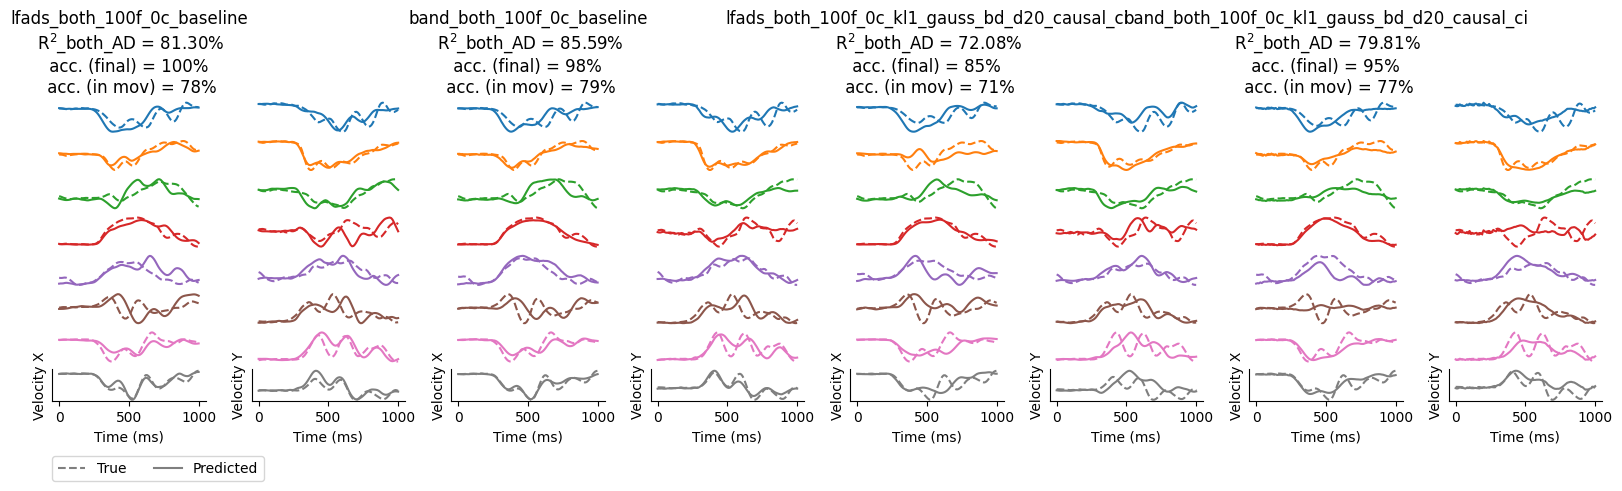

In [76]:


dir_index = np.array([
        sorted(set(true_target_direction)).index(i) for i in true_target_direction
    ])

train_dir_index = np.array([
        sorted(set(train_target_direction)).index(i) for i in train_target_direction
    ])
np.random.seed(1)
trials2plot = np.array([get_random_trials2plot(dir_index, epoch, i) for i in range(3)]).sum(0)

fig, axes = plt.subplots(8, 8, figsize=(20, 5))

for i, (pred_vel, model_name) in enumerate(zip(pred_vels, model_names)):
    
    plot_beh_pred(vel[epoch==1], pred_vel[epoch==1], dir_index[epoch==1], train_vel, train_dir_index, 
                  trials2plot[epoch==1], axes[:, 2*i], area='both', epoch_name='AD', component=0,
                  title=model_name)
    
    plot_beh_pred(vel[epoch==1], pred_vel[epoch==1], dir_index[epoch==1], train_vel, train_dir_index, 
                  trials2plot[epoch==1], axes[:, 2*i+1], area='both', epoch_name='AD', component=1,
                  title=None)
    
    if i == 0:
        axes[-1,0].legend(['True','Predicted'],ncol=2, loc=(0,-2.5 ))
    
plt.subplots_adjust(wspace=0.3, hspace=0.2,bottom=0.2, top=0.8)

In [77]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        np.sum(v[t]**2,axis=-1)**0.5 if component == 'norm' else v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    if component == 'norm':
        axes[-1].set_ylabel("Velocity norm")
    else:
        component_names = ['Velocity X', 'Velocity Y']
        axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,0,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = r2_score(pred_vel,vel)
    # class_acc = 

    ttl = axes[0].set_title(fr'{title}: R$^2$ = {np.round(R2_iso_vel*100):.0f}%',loc='left')
    ttl.set_position([-.3, 1.1])

from scipy.fft import fft, fftfreq

def plot_fourier(ax, ax_p, V, V_true, dt=0.01, label='', 
                 c='k', linestyle='solid', peak_freq = 5,
                 text_pos = None):

        SR = []
        cos_sim = []
        for _ in range(100):

            idxs = np.random.choice(V.shape[0], V.shape[0], replace=True)

            x = V[idxs]
            xf = fft(x)  # Compute Fourier transform of x
            Sxx_all = (xf * xf.conj()).real # Compute power spectrum
            
            SR.append(np.sqrt(Sxx_all).mean(0))

            if V_true is not None:
                x_true = V_true[idxs]
                xf_true = fft(x_true)  # Compute Fourier transform of x_true
                cos = np.cos(np.angle(xf) - np.angle(xf_true))
                cos_sim.append(cos.mean(0))

        faxis = fftfreq(Sxx_all.shape[1]) / dt  # Construct frequency axis
        SR = np.asarray(SR) # [samples, freq]

        mask = (faxis > 0) & (faxis <= 10)
        ax.plot(
            faxis[mask],
            SR.mean(0)[mask],c=c, label=label, linestyle=linestyle)
        
        ax.fill_between(
            faxis[mask],
            SR.mean(0)[mask] - SR.std(0)[mask],
            SR.mean(0)[mask] + SR.std(0)[mask],
            alpha=0.3, color=c
        )

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel(r'FFT Amplitude [cm/s]')
        ax.set_ylim([0,150])
        ax.set_xlim([0,10])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True)

        if V_true is not None:
            cos_sim = np.asarray(cos_sim) # [samples, freq]

            ax_p.plot(
                faxis[mask],
                cos_sim.mean(0)[mask],c=c, label=label, linestyle=linestyle)
            
            ax_p.fill_between(
                faxis[mask],
                cos_sim.mean(0)[mask] - cos_sim.std(0)[mask],
                cos_sim.mean(0)[mask] + cos_sim.std(0)[mask],
                alpha=0.3, color=c
            )
            ax_p.set_xlabel('Frequency [Hz]')
            ax_p.set_ylabel(r'FFT phase similarity')
            ax_p.set_ylim([-0.2,1])
            ax_p.set_xlim([0,10])
            ax_p.spines['top'].set_visible(False)
            ax_p.spines['right'].set_visible(False)
            ax_p.grid(True)

            if text_pos is not None:
                idx_peak = np.argmin(np.abs(faxis - peak_freq))
                ax_p.text(text_pos[0], text_pos[1], 
                          r'cos$_{5Hz}$=' + f'{cos_sim.mean(0)[idx_peak]:.2f}', fontsize=10, color=c)


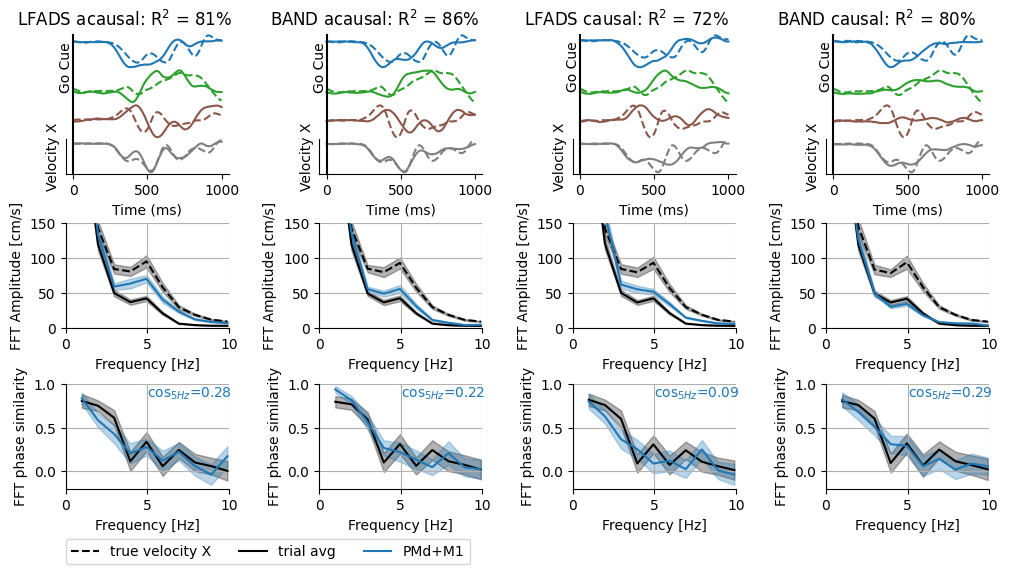

In [78]:


fig = plt.figure(figsize=(15, 7))
# fig.add_axes([0,0,1,1])
axes = np.empty((4,4),dtype=object)
axes_fourier = np.empty(4,dtype=object)
axes_phase = np.empty(4,dtype=object)
mx = 0.02
my = 0.08
col_width = (1-mx) / 5.8

for j in range(4):
    for i in range(4):
        axes[i,j] = fig.add_axes([2*mx + j*col_width,
                                  .84-my-(i+1)/20,
                                  (1-mx)/9,
                                  1/20])
    axes_fourier[j] = fig.add_axes([2*mx + j*col_width,
                                    .92-my-5/20 - 0.25,
                                    (1-mx)/9,
                                    .15])
    
    axes_phase[j] = fig.add_axes([2*mx + j*col_width,
                                    .69-my-5/20 - 0.25,
                                    (1-mx)/9,
                                    .15])

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0 # velocity X

titles = ['LFADS acausal',
          'BAND acausal',
          'LFADS causal',
          'BAND causal']

for i, (pred_vel, model_name,title) in enumerate(zip(pred_vels, model_names,titles)):
    plot_beh_pred(vel[epoch_mask], 
                pred_vel[epoch_mask], 
                dir_index[epoch_mask], 
                trials2plot[epoch_mask], 
                axes[:,i], 
                'all',
                epoch_name,
                select = np.array([0,2,5,7]),
                component=component, 
                title=title)


colors = {'all': 'C0', "PMd": 'C1', "M1": 'C2'}
for i, pred_vel in enumerate(pred_vels):
    label = 'PMd+M1'
    
    plot_fourier(axes_fourier[i], axes_phase[i],
                    vel[epoch_mask][...,component],
                    None, 
                    dt=0.01, label='true velocity X', c='k', linestyle='--',)
    plot_fourier(axes_fourier[i], axes_phase[i], 
                    data['test_all_avg_per_epoch_pred'][epoch_mask][...,component], 
                    vel[epoch_mask][...,component],
                    dt=0.01, label='trial avg', c='k')
    plot_fourier(axes_fourier[i], axes_phase[i],
                    pred_vel[epoch_mask][...,component], 
                    vel[epoch_mask][...,component],
                    dt=0.01, label=label, c=colors['all'],
                    text_pos = (5,0.85))
    if i == 1:
        # horizontal legend
        axes_fourier[i].legend(loc=(-1.55,-2.25),ncol=5)

fig.savefig("figs/Figure3_no_controller.pdf")